# EP fluxes

** include background**




In [1]:
# load modules 

import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
%matplotlib inline
import os 
from xgcm import Grid
from xarrayutils import aggregate
import copy
# Pseudo Inversion 
from scipy.linalg import pinv, eig 

In [2]:
# load time averaged model variables
ds_model = xr.open_dataset('model_trac_restore_tave.nc')

In [9]:
# vars for plotting
X = ds_model.XC/1e3
Y = ds_model.YC/1e3
Z = ds_model.Z

## Mean Flow

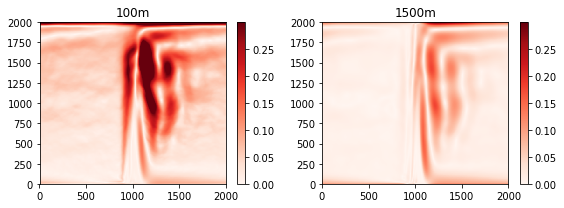

In [16]:
# plot mean speed
fig, ax = plt.subplots(1,2, figsize=(8,3))


im = ax[0].pcolormesh(X, Y, ((ds_model.UmeanC**2 + ds_model.VmeanC**2)**0.5).sel(Z=-100, method='nearest'), vmax=0.3, cmap='Reds') 
ax[0].set_title('100m')
fig.colorbar(im , ax=ax[0])

im = ax[1].pcolormesh(X, Y, ((ds_model.UmeanC**2 + ds_model.VmeanC**2)**0.5).sel(Z=-1500, method='nearest'), vmax=0.3, cmap='Reds' ) 
ax[1].set_title('1500m')
fig.colorbar(im, ax=ax[1])
plt.tight_layout()

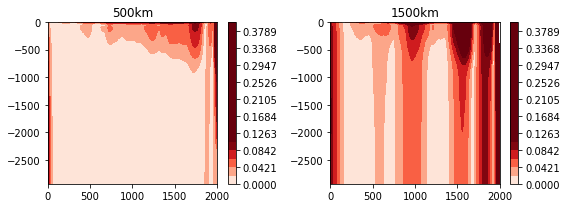

In [22]:
# plot mean speed
fig, ax = plt.subplots(1,2, figsize=(8,3))

levels= np.linspace(0,0.4,20)

im = ax[0].contourf( Y, Z, ((ds_model.UmeanC**2 + ds_model.VmeanC**2)**0.5).sel(XC=500e3, method='nearest'), 
                    levels = levels, vmax=0.1, cmap='Reds') 
ax[0].set_title('500km')
fig.colorbar(im , ax=ax[0])

im = ax[1].contourf( Y, Z, ((ds_model.UmeanC**2 + ds_model.VmeanC**2)**0.5).sel(XC=1500e3, method='nearest'), 
                    levels=levels, vmax=0.1, cmap='Reds' ) 
ax[1].set_title('1500km')
fig.colorbar(im, ax=ax[1])
plt.tight_layout()

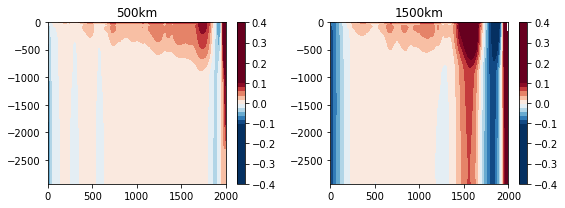

In [26]:
# plot mean speed
fig, ax = plt.subplots(1,2, figsize=(8,3))

levels= np.linspace(-0.4,0.4,41)

im = ax[0].contourf( Y, Z, (ds_model.UmeanC).sel(XC=500e3, method='nearest'), 
                    levels = levels, vmin=-0.1,vmax=0.1, cmap='RdBu_r') 
ax[0].set_title('500km')
fig.colorbar(im , ax=ax[0])

im = ax[1].contourf( Y, Z, (ds_model.UmeanC).sel(XC=1500e3, method='nearest'), 
                    levels=levels, vmin=-0.1,vmax=0.1, cmap='RdBu_r' ) 
ax[1].set_title('1500km')
fig.colorbar(im, ax=ax[1])
plt.tight_layout()

## EP Fluxes

In [27]:
grid = Grid(ds_model, periodic='XC')

In [29]:
# no spatial averaging
upvp = grid.interp(grid.interp(ds_model.UVtave , 'X'), 'Y', boundary='extend') \
                   - ds_model.UmeanC*ds_model.VmeanC
vpvp = grid.interp(ds_model.VVtave, 'Y', boundary='extend')  - ds_model.VmeanC**2
upup = grid.interp(ds_model.UUtave, 'X') - ds_model.UmeanC**2

uptp = ds_model.UTtave - ds_model.UmeanC*ds_model.Ttave
vptp = ds_model.VTtave - ds_model.VmeanC*ds_model.Ttave

tptp = ds_model.TTtave - ds_model.Ttave**2

In [31]:
# b = g alpha T 
g= 9.81
alpha = 2e-4 
f0 = -1.1e-4
upbp = g*alpha*uptp
vpbp = g*alpha*vptp
bpbp = (g*alpha)**2*tptp

In [121]:
N2 = -grid.interp(grid.diff(ds_model.Ttave, 'Z', boundary='extend'), 
                 'Z', boundary='extend')/ds_model.drF

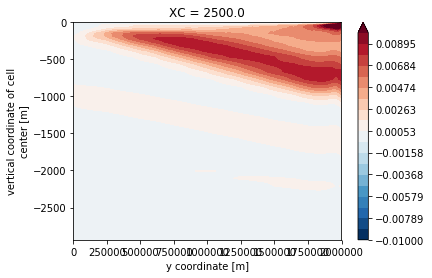

In [122]:
N2.sel(XC=0, method='nearest').plot.contourf(vmin=-1e-2, levels=20)

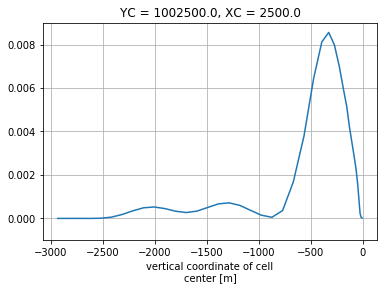

In [128]:
N2.sel(XC=0, YC=1000e3, method='nearest').plot()
plt.ylim([-1e-3, 9e-3])
plt.grid()

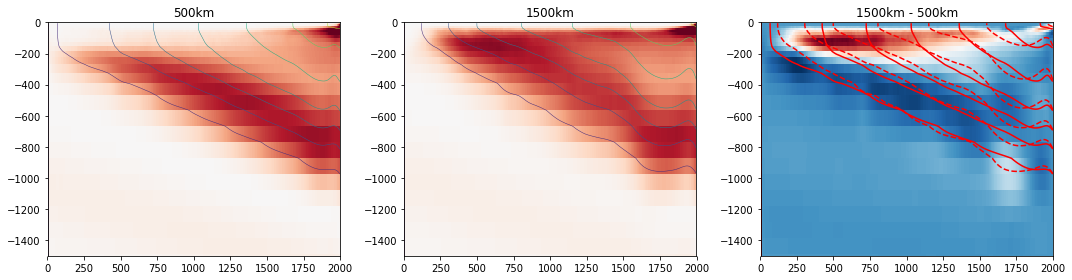

In [59]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

ax[0].pcolormesh(Y, Z, N2.sel(XC=500e3, method='nearest'), cmap='RdBu_r',vmin=-2e-5, vmax=2e-5)
ax[0].contour(Y,Z, ds_model.Ttave.sel(XC=500e3, method='nearest'), linewidths=.5)
ax[0].set_ylim([-1500, 0])
ax[0].set_title('500km')

ax[1].pcolormesh(Y, Z, N2.sel(XC=1500e3, method='nearest'), cmap='RdBu_r',vmin=-2e-5, vmax=2e-5)
ax[1].contour(Y,Z, ds_model.Ttave.sel(XC=1500e3, method='nearest'), linewidths=.5)
ax[1].set_ylim([-1500, 0])
ax[1].set_title('1500km')

ax[2].pcolormesh(Y, Z, (N2.sel(XC=1500e3, method='nearest') - N2.sel(XC=500e3, method='nearest')), cmap='RdBu_r')
ax[2].contour(Y,Z, ds_model.Ttave.sel(XC=1500e3, method='nearest'), linewidths=1.5, linestyles='dashed', colors='r')
ax[2].contour(Y,Z, ds_model.Ttave.sel(XC=500e3, method='nearest'), linewidths=1.5, colors='r')
ax[2].set_ylim([-1500, 0])
ax[2].set_title('1500km - 500km')
# almost all the difference is a result of isopycnal heaving.

plt.tight_layout()


\begin{equation}
\mathbf{E}_1 = (\overline{u'v'}) \mathbf{i} + 
\frac{1}{2} \left(\overline{v'^2 - u'^2 +\frac{b'^2}{N^2}} \right) \mathbf{j} + 
\left(\frac{f_o}{N^2} \overline{u'b'} \right) \mathbf{k}
\end{equation}

\begin{equation}
\mathbf{E}_2 =  \frac{1}{2} \left(\overline{v'^2 - u'^2 -\frac{b'^2}{N^2}} \right) \mathbf{i} 
-(\overline{u'v'}) \mathbf{j} +
\left(\frac{f_o}{N^2} \overline{v'b'} \right) \mathbf{k}
\end{equation}
The horizontal PV fluxes are given by the divergences 

\begin{equation}
\overline{u'q'} = \nabla. \mathbf{E}_1
\end{equation}

\begin{equation}
\overline{v'q'} = \nabla. \mathbf{E}_2
\end{equation}


In [67]:
E1i = upvp
E11j = 0.5*(vpvp - upup)
E12j = 0.5*(bpbp/N2)
E1k = f0/N2*upbp

In [70]:
E21i = 0.5*(vpvp - upup)
E22i = 0.5*(-bpbp/N2)
E2j = -upvp
E2k = f0/N2*vpbp

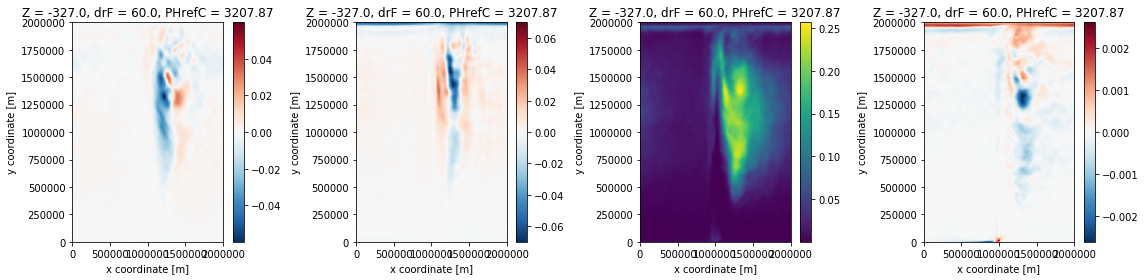

In [96]:
fig = plt.figure(figsize=(16,4))

fig.add_subplot(141)
E1i.sel(Z=-300, method='nearest').plot()

fig.add_subplot(142)
E11j.sel(Z=-300, method='nearest').plot()

fig.add_subplot(143)
E12j.sel(Z=-300, method='nearest').plot()

fig.add_subplot(144)
E1k.sel(Z=-300, method='nearest').plot()

# All the individial components of the EP flux vector are different magnitudes.

plt.tight_layout()

In [72]:
# u'q'
dx = ds_model.dxC[0,0]

E1x = grid.interp(grid.diff(E1i, 'X')/dx, 'X')

E11y = grid.interp(grid.diff(E11j, 'Y', boundary='extend'), 'Y', boundary='extend')/dx
E12y = grid.interp(grid.diff(E12j, 'Y', boundary='extend'), 'Y', boundary='extend')/dx

E1z = -grid.interp(grid.diff(E1k, 'Z', boundary='extend'),
                  'Z', boundary='extend')/ds_model.drF

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xgcm-0.1.0-py3.5.egg/xgcm/grid.py:876: RuntimeWarning: invalid value encountered in add
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xgcm-0.1.0-py3.5.egg/xgcm/grid.py:880: RuntimeWarning: invalid value encountered in subtract


In [97]:
# check if there is a large difference if E12 is calculated with N2 inside or outside derivative 
# should be outside derivative, unless constant 
ingrad = 0.5*grid.interp( grid.diff(bpbp/N2, 'Y', boundary='extend'), 'Y', boundary='extend')/dx
outgrad = 0.5/N2*grid.interp( grid.diff(bpbp, 'Y', boundary='extend'), 'Y', boundary='extend')/dx

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xgcm-0.1.0-py3.5.egg/xgcm/grid.py:876: RuntimeWarning: invalid value encountered in add


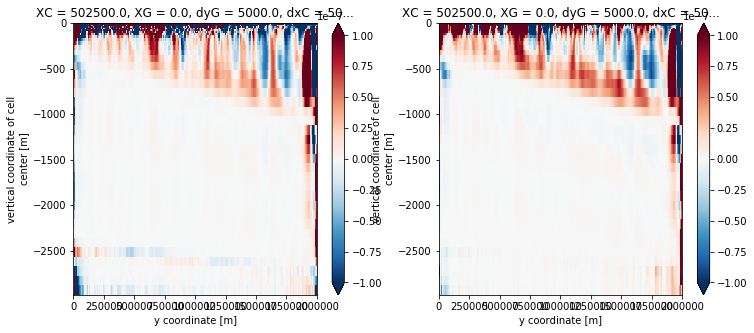

In [103]:
plt.figure(figsize=(12,5))
plt.subplot(121)
ingrad.sel(XC=500e3, method='nearest').plot(vmin=-1e-7)

plt.subplot(122)
outgrad.sel(XC=500e3, method='nearest').plot(vmin=-1e-7)
# looks similar (maybe difference, but should not influence the picture of PV fluxes)


In [ ]:
# v'q'
dx = ds_model.dxC[0,0]

E21x = grid.interp(grid.diff(E21i, 'X')/dx, 'X')
E22x = grid.interp(grid.diff(E22i, 'X')/dx, 'X')

E2y = grid.interp(grid.diff(E2j, 'Y', boundary='extend'), 'Y', boundary='extend')/dx

E2z = -grid.interp(grid.diff(E2k, 'Z', boundary='extend'),
                  'Z', boundary='extend')/ds_model.drF

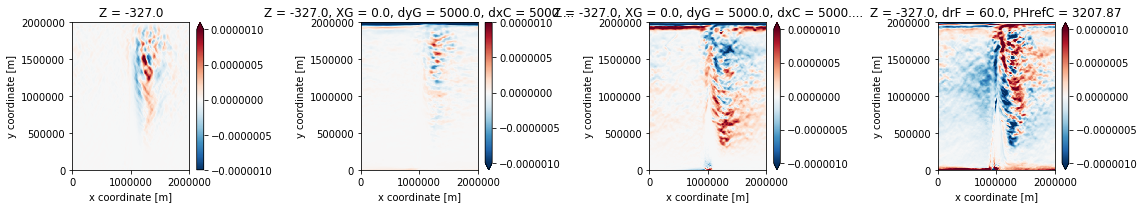

In [78]:
fig = plt.figure(figsize=(16,3))

fig.add_subplot(141)
E1x.sel(Z=-300, method='nearest').plot(vmin=-1e-6)

fig.add_subplot(142)
E11y.sel(Z=-300, method='nearest').plot(vmin=-1e-6)

fig.add_subplot(143)
E12y.sel(Z=-300, method='nearest').plot(vmin=-1e-6)

fig.add_subplot(144)
E1z.sel(Z=-300, method='nearest').plot(vmin=-1e-6)

plt.tight_layout()


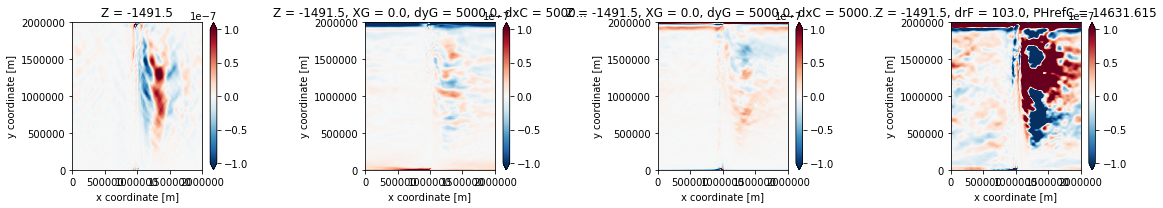

In [80]:
fig = plt.figure(figsize=(16,3))

fig.add_subplot(141)
E1x.sel(Z=-1500, method='nearest').plot(vmin=-1e-7)

fig.add_subplot(142)
E11y.sel(Z=-1500, method='nearest').plot(vmin=-1e-7)

fig.add_subplot(143)
E12y.sel(Z=-1500, method='nearest').plot(vmin=-1e-7)

fig.add_subplot(144)
E1z.sel(Z=-1500, method='nearest').plot(vmin=-1e-7)

plt.tight_layout()

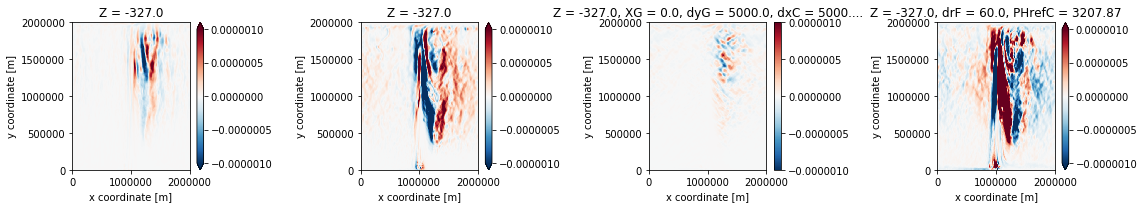

In [81]:
fig = plt.figure(figsize=(16,3))

fig.add_subplot(141)
E21x.sel(Z=-300, method='nearest').plot(vmin=-1e-6)

fig.add_subplot(142)
E22x.sel(Z=-300, method='nearest').plot(vmin=-1e-6)

fig.add_subplot(143)
E2y.sel(Z=-300, method='nearest').plot(vmin=-1e-6)

fig.add_subplot(144)
E2z.sel(Z=-300, method='nearest').plot(vmin=-1e-6)

plt.tight_layout()

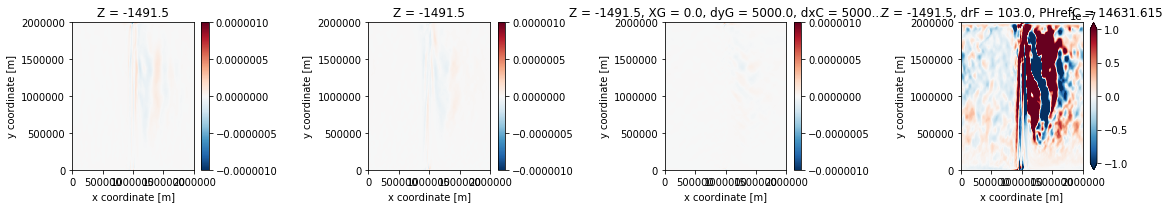

In [91]:
fig = plt.figure(figsize=(16,3))

fig.add_subplot(141)
E21x.sel(Z=-1500, method='nearest').plot(vmin=-1e-6)

fig.add_subplot(142)
E22x.sel(Z=-1500, method='nearest').plot(vmin=-1e-6)

fig.add_subplot(143)
E2y.sel(Z=-1500, method='nearest').plot(vmin=-1e-6)

fig.add_subplot(144)
E2z.sel(Z=-1500, method='nearest').plot(vmin=-1e-7)

plt.tight_layout()

In [105]:
upqp = E1x + E11y + E12y + E1z
vpqp = E21x + E22x + E2y + E2z

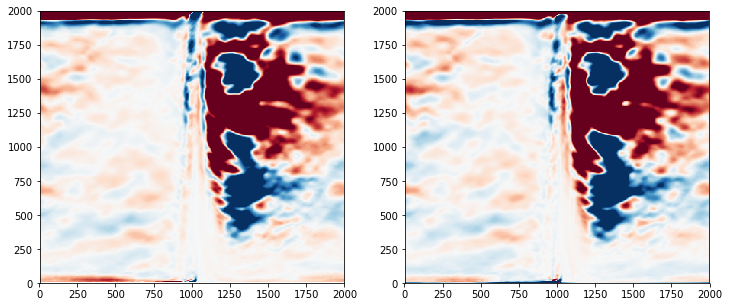

In [110]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].pcolormesh(X, Y, upqp.sel(Z=-1500, method='nearest'), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')

ax[1].pcolormesh(X, Y, E1z.sel(Z=-1500, method='nearest'), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')

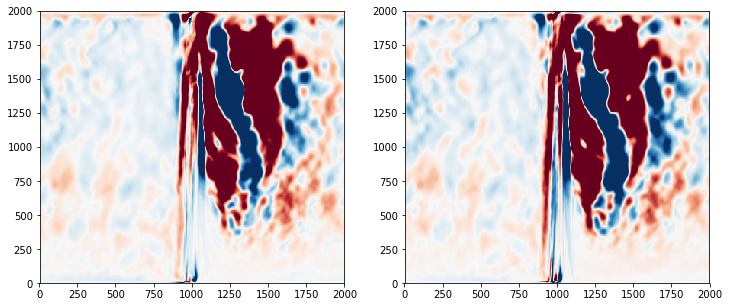

In [111]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].pcolormesh(X, Y, vpqp.sel(Z=-1500, method='nearest'), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')

ax[1].pcolormesh(X, Y, E2z.sel(Z=-1500, method='nearest'), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')

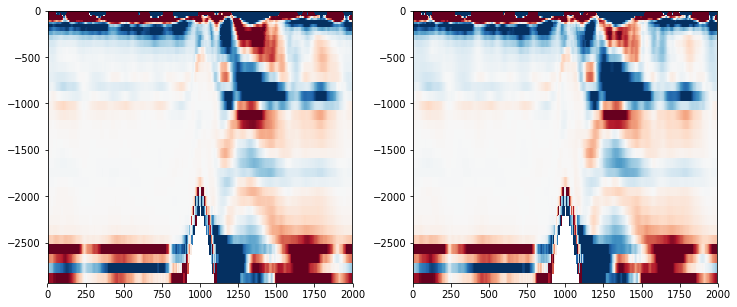

In [113]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].pcolormesh(Y, Z, upqp.sel(YC=1000e3, method='nearest'), vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')

ax[1].pcolormesh(Y, Z, E1z.sel(YC=1000e3, method='nearest'), vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')

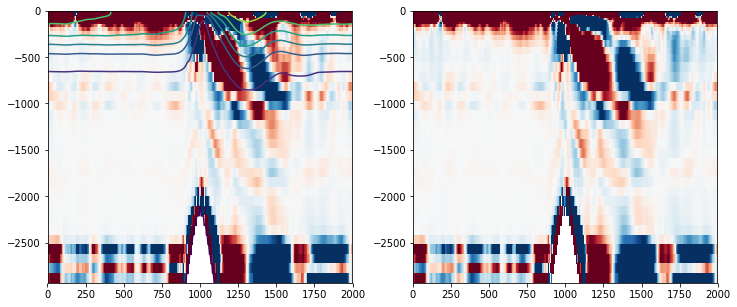

In [116]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].pcolormesh(Y, Z, vpqp.sel(YC=1000e3, method='nearest'), vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')
ax[0].contour(Y,Z , ds_model.Ttave.sel(YC=1000e3, method='nearest'))

ax[1].pcolormesh(Y, Z, E2z.sel(YC=1000e3, method='nearest'), vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')

## Zonal Averaging

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


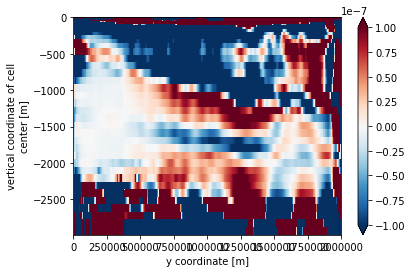

In [87]:
(E1z*ds_model.hFacC).mean('XC').plot(vmin = -1e-7)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


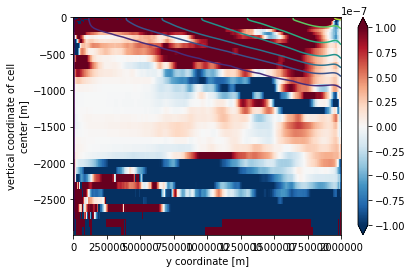

In [95]:
(E2z*ds_model.hFacC).mean('XC').plot(vmin = -1e-7)
ds_model.Ttave.mean('XC').plot.contour(levels=np.linspace(0,8,9),)